In [ ]:
# Libraries:

library(here) # setting the paths
library(corrplot) # plotting correlation
library(dendextend) # plotting dendrogram
library(data.table) # working with data frames:
library(raster) # working with raster layers
library(rgdal)

In [2]:
# Paths to existing files
path2past <- here("data","environmental","past","masked")
path2present <- here("data","environmental","present","masked")
path2env_table<-here("outputs","Predictor_variables.csv")
path2counties<-here("raw_data","CHN_adm")


In [3]:
# Paths to outputs
path2pearson <- here("outputs","Predictors_autocorrelation.csv")
path2corrplot <- here("outputs","Predictors_corrplot.tiff")
path2dendrogram<-here("outputs","Predictors_dendrogram.pdf")

# Environmental data:

path2env_present <- here("data","env_present.csv")
path2stats<-here("data","Mean_and_SD.csv")
path2env_std<-here("data","env_present_std.csv")
path2env_past<-here("data","env_past.csv")
path2env_past_std<-here("data","env_past_std.csv")

In [4]:
### Load data
# Load the list of variables names (will be needed to change the names later):
var_list<-read.csv(path2env_table)
                   
### Loading data:

# Get vector map of counties in China
china<-readOGR(dsn = path2counties, layer = "CHN_adm3")

OGR data source with driver: ESRI Shapefile 
Source: "G:\My Drive\my_repositories\PhD\raw_data\CHN_adm", layer: "CHN_adm3"
with 2409 features
It has 13 fields
Integer64 fields read as strings:  ID_0 ID_1 ID_2 ID_3 


In [5]:
# Get list of folders that contain past environmental layers
layers<-list.files(path=path2past,full.names=TRUE)
# Include only npp, and bioclimatic variables, with the exception of BIO3, BIO14, and BIO15, as these are known to cause issues
layers<-subset(layers,lapply(layers, grepl,pattern="BIO3|BIO14|BIO15")==FALSE)
# Get list of files in the folder for each variable
layers<-lapply(layers,list.files,full.names=TRUE, pattern=".tif")
# Order layers chronologically
layers<-lapply(layers, function(x) return(x[c(1,4:11,2,3)]))

In [30]:
egv_list<-lapply(layers,raster::stack)

In [31]:
# Make a list of stacks grouped by period
egv_by_period<-c()
for(i in 1:length(layers[[1]])){
a<-raster::stack(lapply(egv_list, subset,i))
egv_by_period[[i]]<-c(a)}
egv_by_period <- unlist(egv_by_period)

In [32]:
# Load layers for present climatic variables:
p_layers<-list.files(path=path2present,pattern='tif',full.names=TRUE)
# Get only the layers related to bioclimatic variables and net primary productivity, and exclude bioclimatic variables 3, 14 and 15, because of the recommendations
p_layers<-subset(p_layers,lapply(p_layers, grepl,pattern="BIO|npp")==TRUE &lapply(p_layers, grepl,pattern="BIO3|BIO14|BIO15")==FALSE)
# Join all rasters in a single object
egv<-stack(p_layers)

In [33]:
# Extract the dataframe of variables from all of the layers
prd_list<-lapply(egv_by_period,values)
prd_list<-lapply(prd_list,as.data.frame)
prd_list<-lapply(prd_list,function(x){colnames(x)<-sub('_.*','',colnames(x))
                                      return(x)})

In [34]:
# Also extract the dataframe of variables for the present layer:
pres<-values(egv)

In [35]:
# Merges the data frame of present predictors with a data frame of past predictors
predictors<-rbind(pres,rbindlist(prd_list))

In [38]:
### Calculate the correlation coefficient matrix
pearson<-cor(predictors, method = "pearson",use="complete.obs")
# Save the correlation coefficient matrix to csv
write.csv(pearson, file=path2pearson,row.names=TRUE)

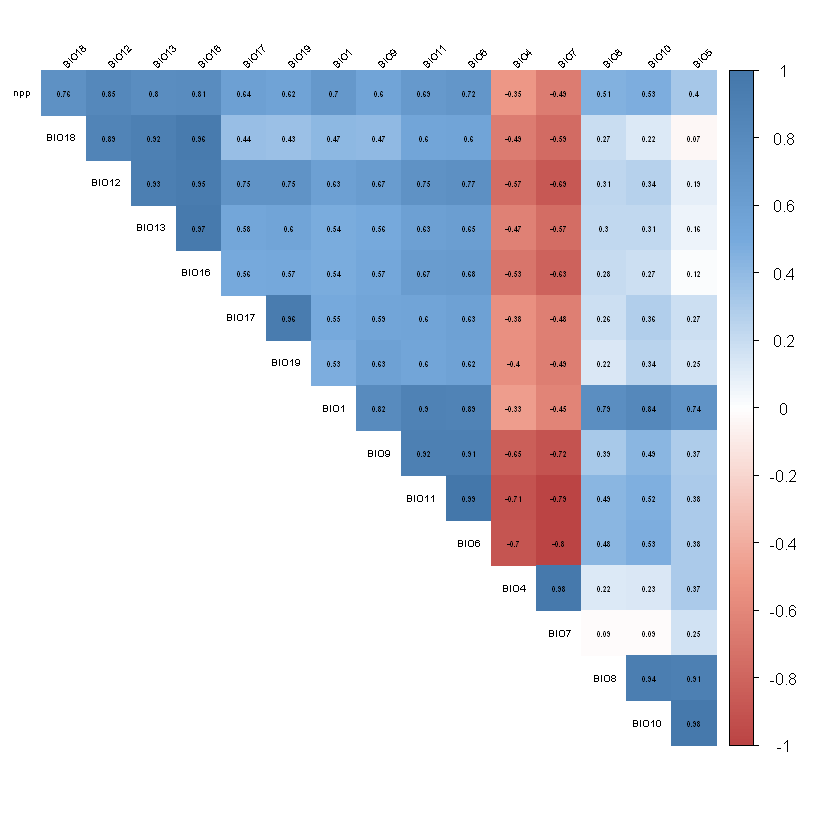

In [68]:
### Create a graph showing the correlation coefficients
# Set color palette
col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

# Create a correlation plot and save it as a tiff file:
#tiff(path2corrplot, units="cm", width=17.4, height=17.4, res=600,bg = "transparent")
corrplot(as.matrix(pearson), method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
         sig.level = 0.01, insig = "blank", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE,number.cex=0.4,tl.cex=0.5
         )
#dev.off()

In [39]:
### Plot the dendrogram:
# Transform the correlation coefficient into a data.frame
cor.df<-as.data.frame(pearson)
# Change the names for plotting in the dendrogram
var_names<-colnames(cor.df)
rownames(cor.df)<-colnames(cor.df) <-unlist(lapply(var_names,function(x){return(var_list[which(var_list[,1]==x),2])}))
# Transfrom correlation matrix to distances
var.dist <- abs(as.dist(cor.df))
# Calculate dendrogram based on distance (less distance = more correlation)
var.cluster <- hclust(1-var.dist)
# Turn into dendrogram
dd<-as.dendrogram(var.cluster)

In [72]:
# Plot the dendrogram showing the clusters of higly correlated predictors:
labels_colors(dd) <- c("black","red","black","red","black","red","black","black","black","black","red","black","black","red","black","black")
pdf(path2dendrogram, width=6.85, height=6.85,bg = "transparent")
par(mar=c(4,4,0,20))
plot(dd, main="",ylab="distance", xlab="",sub=NA, cex=0.75,col=c("red","blue","black","yellow"),horiz=T)
abline(v=0.25, lty=2, lwd=2)
dev.off()

png 
  2

### Standardize environmental variables, based on the mean and present for the modern distribution:

In [7]:
# Define variables that will be included in the analysis (are not autocorrelated)
var_names=c("BIO10","BIO17","BIO4","BIO9","npp")

# List all files with environmental variables
layers<-list.files(path=path2present,pattern='tif$',full.names=TRUE)
env_layers<-subset(layers,lapply(layers, grepl,pattern=paste(var_names,collapse="|"))==TRUE) # for the present

# List all files with environmental variables for the past
# Get list of folders that contain past environmental layers
layers<-list.files(path=path2past,full.names=TRUE)
past_layers<-subset(layers,lapply(layers, grepl,pattern=paste(var_names,collapse="|"))==TRUE) #for the present
# Get list of files in the folder for each variable
past_layers<-lapply(past_layers,list.files,full.names=TRUE, pattern=".tif")
# Order layers chronologically
past_layers<-lapply(past_layers, function(x) return(x[c(1,4:11,2,3)]))

In [94]:
env<-stack(env_layers)

In [95]:
# Extract weighted mean raster values of the cells for environmental variables for each county in China
r.mean <- extract(env,china,weights=TRUE,normalizeWeights=TRUE,fun="mean",na.rm=TRUE,df=TRUE) # Try to change to cropped if it does not work

Warning message in .local(x, y, ...):
""fun" was changed to "mean"; other functions cannot be used when "weights=TRUE""


In [ ]:
# Check that no county has missing values:
sums<-rowSums(r.mean)
mc<-which(is.na(sums))

In [ ]:
write.csv(r.mean[,-1],path2env_present,row.names=FALSE)

In [ ]:
# Get mean and standard deviation:

sd<-apply(r.mean,2,sd)
mean<-apply(r.mean,2,mean)


In [ ]:
stats<-rbind(mean,sd)
stats<-t(as.data.frame(stats[,-1]))

In [ ]:
# Save the mean and standard deviation used for scaling and centering of the variables:
write.csv(stats, file=path2stats)

In [ ]:
# Standardize data
std_data<-lapply(var_names,function(x){
    data_sub<-r.mean[,grep(x,colnames(r.mean))]
    new_columns<-scale(data_sub,center=stats[x,]$mean,scale=stats[x,]$sd)
    new_columns<-as.data.frame(new_columns)
    colnames(new_columns)<-paste(x,"sd",sep="_")
    return(new_columns)})

In [ ]:
std_data<-data.frame(std_data)

In [ ]:
write.csv(std_data,path2env_sd)

In [8]:
# Get list of folders that contain past environmental layers
layers<-list.files(path=path2past,full.names=TRUE)
# Include only relevant variables
layers<-subset(layers,lapply(layers, grepl,pattern=paste(var_names,collapse="|"))==TRUE)
# Get list of files in the folder for each variable
layers<-lapply(layers,list.files,full.names=TRUE, pattern=".tif")
# Order layers chronologically
layers<-lapply(layers, function(x) return(x[c(1,9:16,2:8)]))

In [9]:
env<-stack(unlist(layers))

In [11]:
r.mean <- extract(env,china,weights=TRUE,normalizeWeights=TRUE,fun="mean",na.rm=TRUE,df=TRUE) # Try to change to cropped if it does not work

Warning message in .local(x, y, ...):
""fun" was changed to "mean"; other functions cannot be used when "weights=TRUE""


In [13]:
path2env_past

[1] "G:/My Drive/my_repositories/PhD/data/env_past.csv"

In [13]:
write.csv(r.mean, path2env_past, row.names=FALSE)

In [14]:
stats<-read.csv(path2stats,row.names=1)

In [16]:
var_names=c("BIO10","BIO17","BIO4","BIO9","npp")

In [17]:
# Standardize data
std_data<-lapply(var_names,function(x){
    data_sub<-r.mean[,grep(x,colnames(r.mean))]
    new_columns<-scale(data_sub,center=rep(stats[x,]$mean,ncol(data_sub)),scale=rep(stats[x,]$sd,ncol(data_sub)))
    new_columns<-as.data.frame(new_columns)
    colnames(new_columns)<-paste(colnames(new_columns),"sd",sep="_")
    return(new_columns)})

In [18]:
std_data<-data.frame(std_data)

In [21]:
write.csv(std_data,path2env_past_std,row.names=FALSE)